# Ant Colony Optimization

The first thing we will do is write a simple script that simulates the foraging behaviour of ants, adapted from the following sources on Ant Colony Optimization (ACO)

1. [ACO_Wiki](https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms)
2. [Continious Orthogonal Ant Optimazation](https://link.springer.com/article/10.1007%2Fs11390-008-9111-5)

## Create a moving Agent

The first step in creating out ACO algorithm is to create a moving agent that changes direction with subtle randomness. To do this we implement the two classes below. The first class is the field the agents will move in, and the second is the actual agent class with some basic movement functionality that includes the ability to change direction after some time.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.animation as animation
from fiblat import sphere_lattice as sphere

# Set up a seed
SEED = 1234567890
np.random.seed(SEED)

In [2]:
# Global Helper functions
def unit(x):
    '''Returns a unit vector for x'''
    if np.dot(x,x) == 0: return 0
    return x/np.sqrt(np.dot(x,x))

# Creates random evenly spaced points on a unit n-sphere
def points_on_sphere(n:int,points:int):
    if n == 2:
        theta = np.linspace(0,2*np.pi,points)
        return np.array([np.cos(theta),np.sin(theta)]).T

    else: return np.array(sphere(n,points))

# We will first create a class for a simple field for everything to live in
class Field:

    # Constructor
    def __init__(self,bounds:np.array=np.array([[0,1],[0,1]]),steps=[100,100],function = lambda x: 0, num_pheromones=3):
        # The bounds of the field
        self.bounds = bounds
        self.dim = len(bounds)

        # The function
        self.function = function

        # Pheromone Matrix
        self.pheromones = np.zeros([*steps,num_pheromones,2])
        self.h = np.array([(b[1] - b[0])/step for b,step in zip(bounds,steps)])
        self.steps = steps


    # Generate a random position within the map
    def random_position(self):
        return np.array([ x*abs(self.bounds[i,1]-self.bounds[i,0]) + min(self.bounds[i]) for i,x in enumerate(np.random.rand(self.bounds.shape[0]))])

    # return a random unit vector with the dimensions of the borad
    def random_unit_vector(self):
        return unit(np.random.rand(self.bounds.shape[0])*2-np.array([1,1]))

    # Checks if a number is inside the box
    def inside(self,x:np.array):
        ans = True
        for i in range(len(x)): ans = ans and (x[i] <= self.bounds[i,1]) and (x[i] >= self.bounds[i,0])
        return ans

    # Returns the normal vector to the point if out of bounds
    def get_normal(self,x:np.array):
        return np.array([np.sign(bi.mean() - xi) if (xi-bi[0])*(xi-bi[1]) > 0 else 0 for xi,bi in zip(x,self.bounds)])

    # Get the index of a position vector inside the field on the pheromone array
    def index(self,x:np.array):
        if not self.inside(x): raise('The vector is not inside the field')
        return tuple(np.clip(np.floor((x-self.bounds.T[0])/self.h + 0.5).astype(dtype=np.int64),a_min=bounds.T[0],a_max=bounds.T[1]))

    # This adds a pheromone to the pheromone matrix
    def add_pheromone(self,x:np.array,value:float=1,time:float=0,state:int=0):
        current = self.pheromones[self.index(x)][state,0]
        self.pheromones[self.index(x)][state] = np.array([value+current,time])

    # This returns the pheromone value from the matrix for a particular state
    def read_pheromone(self,x:np.array,time:float=0,state:int=0,pheromone_time_constant:float=1):
        idx = self.index(x)
        pheromone = self.pheromones[idx][state]
        value = pheromone[0] * np.exp(-abs(time - pheromone[1])/pheromone_time_constant)

        return value

    # Returns the pheromone matrix at the designated time as a numpy array
    def get_pheromones(self,time:float=0,state:int=0):
        pher = np.zeros(self.steps, dtype=np.float)
        for i in range(len(self.pheromones)):
            for j in range(len(self.pheromones[i])):
                pher[i][j] =  self.pheromones[i,j,state,0] * np.exp(-abs(time-self.pheromones[i,j,state,1])/pheromone_time_constant)

        return pher
                
        

# Create a class for an agent
class Agent:
    ID_cnt = 0          # Static variable to hold the IDs

    # Constructor
    def __init__(self,ID:int = -1, pos:np.array = np.array([None,None]), field:Field = Field(), pheromone_level:float = 1, pheromone_time_constant:float = 1):
        
        # Assign a unique ID
        self.ID = Agent.ID_cnt if ID == -1 else ID
        Agent.ID_cnt += 1

        # Assign the field variable
        self.field = field

        # Determine if to create a random position
        self.pos = self.field.random_position() if (pos == np.array([None,None])).all() else pos

        # It's velocity will also be a vector initialized at 0
        self.vel = np.zeros(self.pos.shape)
        self.desired_vel = np.zeros(self.pos.shape)

        # State will tell us if this is a scout or worker
        # Scout   : 0
        # Worker-1: 1
        # Worker-2: 2, etc.
        self.state = 0
        self.pheromone_level = pheromone_level
        self.pheromone_time_constant = pheromone_time_constant

    # This will update the position based on the velocity
    def move(self,dt:float):
        self.pos = self.vel * dt + self.pos

    # This function will sense the direction of minimum gradient
    def grad_direction(self, radius:float=1, Nsamples:int=10, pheromone_strength:float = 1, state:int = 1, time:float = 0):
        # Get the points to search
        test_points = self.pos+points_on_sphere(self.field.dim,Nsamples)*radius

        # Get the gradient around that ring
        grad = (self.field.function(test_points) - self.field.function(self.pos)*np.ones(len(test_points))) / radius

        # Get the pheromones
        if pheromone_strength != 0:
            grad += (np.array([self.read_pheromone(pos=test_point,time=time) for test_point in test_points])
                    - self.read_pheromone(time=time) * np.ones(len(test_points))) / radius * pheromone_strength
    
        # Pick the minimum and return its direction
        return (test_points[np.argmin(grad)]-self.pos) * abs(min(grad))

    # Adds a pheromone to the pheromone matrix in the field
    def add_pheromone(self,time:float=0):
        self.field.add_pheromone(self.pos,self.pheromone_level,time,self.state)

    # Reads the pheromone trail from the field
    def read_pheromone(self,time:float=0,state:int=None,pos:np.array = np.array([None,None])):
        pos = self.pos if (pos == np.array([None,None])).all() else pos
        if state == None: state = self.state

        return self.field.read_pheromone(x=pos,time=time,state=state,pheromone_time_constant=self.pheromone_time_constant)

    # Update angent state based on pheromones
    def update_state(self,time:float=0):
        # Calculate the score of this position by the difference in pheromones VS the function
        F = -self.field.function(self.pos)
        P = self.read_pheromone(time = time,state = 1) + self.pheromone_level
        score = F-P
        
        # If the state is 0:
        if self.state == 0 and score >= 0:
            # print('STATE1 @',self.pos,' with F:',F,'P:',P,'Score:',score)
            self.state = 1

        elif self.state == 1 and score <=0:
            # print('STATE0 @',self.pos,' with F:',F,'P:',P,'Score:',score)
            self.state = 0

        # Finally add a pheromone of the agent's type
        self.add_pheromone(time)

    # Detect and resolve collisions
    def collision_detection(self,pos:np.array,vel:np.array):
        if not self.field.inside(pos):
            n = self.field.get_normal(pos)
            return vel - 2*np.dot(vel,n)*n
        return vel

    # This will update the velocity using certain randomness
    def update_velocity(self, dt:float,
                        acc_magnitude:float     = 1,
                        desired_speed:float     = 1,
                        randomness:float        = 0.5,
                        gradient_strength:float = 1,
                        grad_radius:float       = 1,
                        grad_samples:int        = 10,
                        pheromone_strength:float= 1,
                        time:float              = 0):

        # # First we determine the desired speed
        # if self.state != 0: desired_speed = 0

        # Then we update the desired velocity
        # Get the preferential gradient direction
        gradient = self.grad_direction(radius=grad_radius, Nsamples=grad_samples,pheromone_strength=pheromone_strength,time=time)
        self.desired_vel = unit(self.desired_vel 
                              + self.field.random_unit_vector() * randomness 
                              + gradient * gradient_strength) * desired_speed

        # Now we calculate the acceleration required to reach that speed
        acc = unit(self.desired_vel - self.vel) * acc_magnitude

        # Finally, update the velocity based on the past accelleration
        self.vel = self.vel + acc * dt
        self.vel = self.collision_detection(self.pos+self.vel*dt,self.vel)
        self.desired_vel = self.collision_detection(self.pos+self.desired_vel*dt,self.desired_vel)


In [3]:
# Now we test Let's create a function that would put an agent in a field and run it with our parameters

# Agent motion properties
acc_magnitude           = 2
desired_speed           = 1
randomness              = 10
dt                      = 0.01
max_time                = 10
gradient_strength       =1
grad_radius             =1
grad_samples            =10
pheromone_level         = 1
pheromone_time_constant = 1
pheromone_strength      = 1
s                       = 0.4
func                    = lambda x: -10*np.exp(-x.dot(x)/s**2)
COLORS                  = ['b','r','g','yellow']

def run_one_agent(field:Field,dt=dt,max_time=max_time,acc_magnitude=acc_magnitude,desired_speed=desired_speed,randomness=randomness,gradient_strength=gradient_strength,grad_radius=grad_radius,grad_samples=grad_samples,pos=np.array([0.5,0.5]),pheromone_level = pheromone_level, pheromone_time_constant = pheromone_time_constant,pheromone_strength=pheromone_strength):
    # Create an agent
    agent = Agent(pos=pos,field=field,pheromone_level=pheromone_level,pheromone_time_constant=pheromone_time_constant)      # pos=np.array([0.5,0.5]),

    # Simulate the agent's motion for some arbitrary time
    time = np.arange(0,max_time,dt)
    
    # An array to solve the position
    pos = [agent.pos]
    color = [COLORS[agent.state]]

    # Simulate
    for t in time:
        agent.update_velocity(dt,acc_magnitude,desired_speed,randomness,gradient_strength,grad_radius,grad_samples,pheromone_strength,t)
        agent.move(dt)
        agent.update_state(t)

        pos.append(agent.pos)
        color.append(COLORS[agent.state])

    pos = np.array(pos)
    color = np.array(color)

    return pos,color

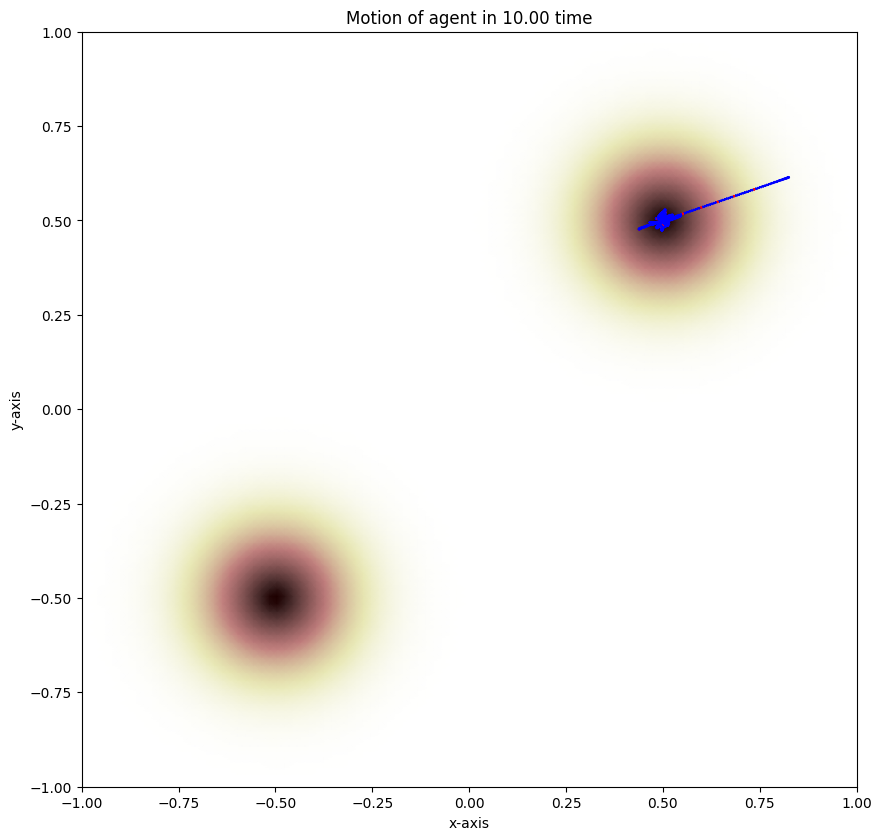

In [5]:
# Agent motion properties
acc_magnitude           = 2
desired_speed           = 0.5
randomness              = 1e-1
dt                      = 0.01
max_time                = 10
gradient_strength       = 1e+4
grad_radius             = 1e-4
grad_samples            = 10
bounds                  = np.array([[-1,1],[-1,1]])
steps                   = [50,50]
pheromone_level         = 1e+0
pheromone_time_constant = 1e+0
pheromone_strength      = 1e+4
s                       = 2e-1
A                       = 5
pos                     = np.array([None,None]) # np.array([0.5,0.5])
def func(x): 
    if len(x.shape) == 1:
        p1 = np.array([0.5,0.5])
        p2 = np.array([-0.5,-0.5])
        return -A*np.exp(-np.dot(x-p1,x-p1)/s**2) -A*np.exp(-np.dot(x-p2,x-p2)/s**2)
    else:
        return np.array([func(xi) for xi in x])
def F (x,y):
    p1 = np.array([0.5,0.5])
    p2 = np.array([-0.5,-0.5])
    return -np.exp(-((x-p1[0])**2 + (y-p1[1])**2)/s**2) -np.exp(-((x-p2[0])**2 + (y-p2[1])**2)/s**2)

# Now plot the position array
field = Field(bounds=bounds,steps=steps,function=func)

pos,color = run_one_agent(field,dt,max_time,acc_magnitude,desired_speed,randomness,gradient_strength,grad_radius,grad_samples,pos,pheromone_level, pheromone_time_constant)

# Create the figure and setup athe axis
fig = plt.figure(figsize=(10,10),dpi=100)
ax  = fig.add_subplot(111)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('Motion of agent in %.2f time'%max_time)
ax.set_xlim(*field.bounds[0])
ax.set_ylim(*field.bounds[1])

# Plot the mesh
x = np.linspace(*bounds[0],100)
y = np.linspace(*bounds[1],100)
X,Y = np.meshgrid(x,y)
Z = F(X,Y)
ax.pcolormesh(X,Y,Z,cmap='pink', shading='gouraud')

# plot the position
ax.scatter(*(pos.T),s=1,marker='x',c=color);

In [21]:
# A counter for our animations
anim_cnt = 0

100%|██████████| 250/250 [05:45<00:00,  1.38s/it]


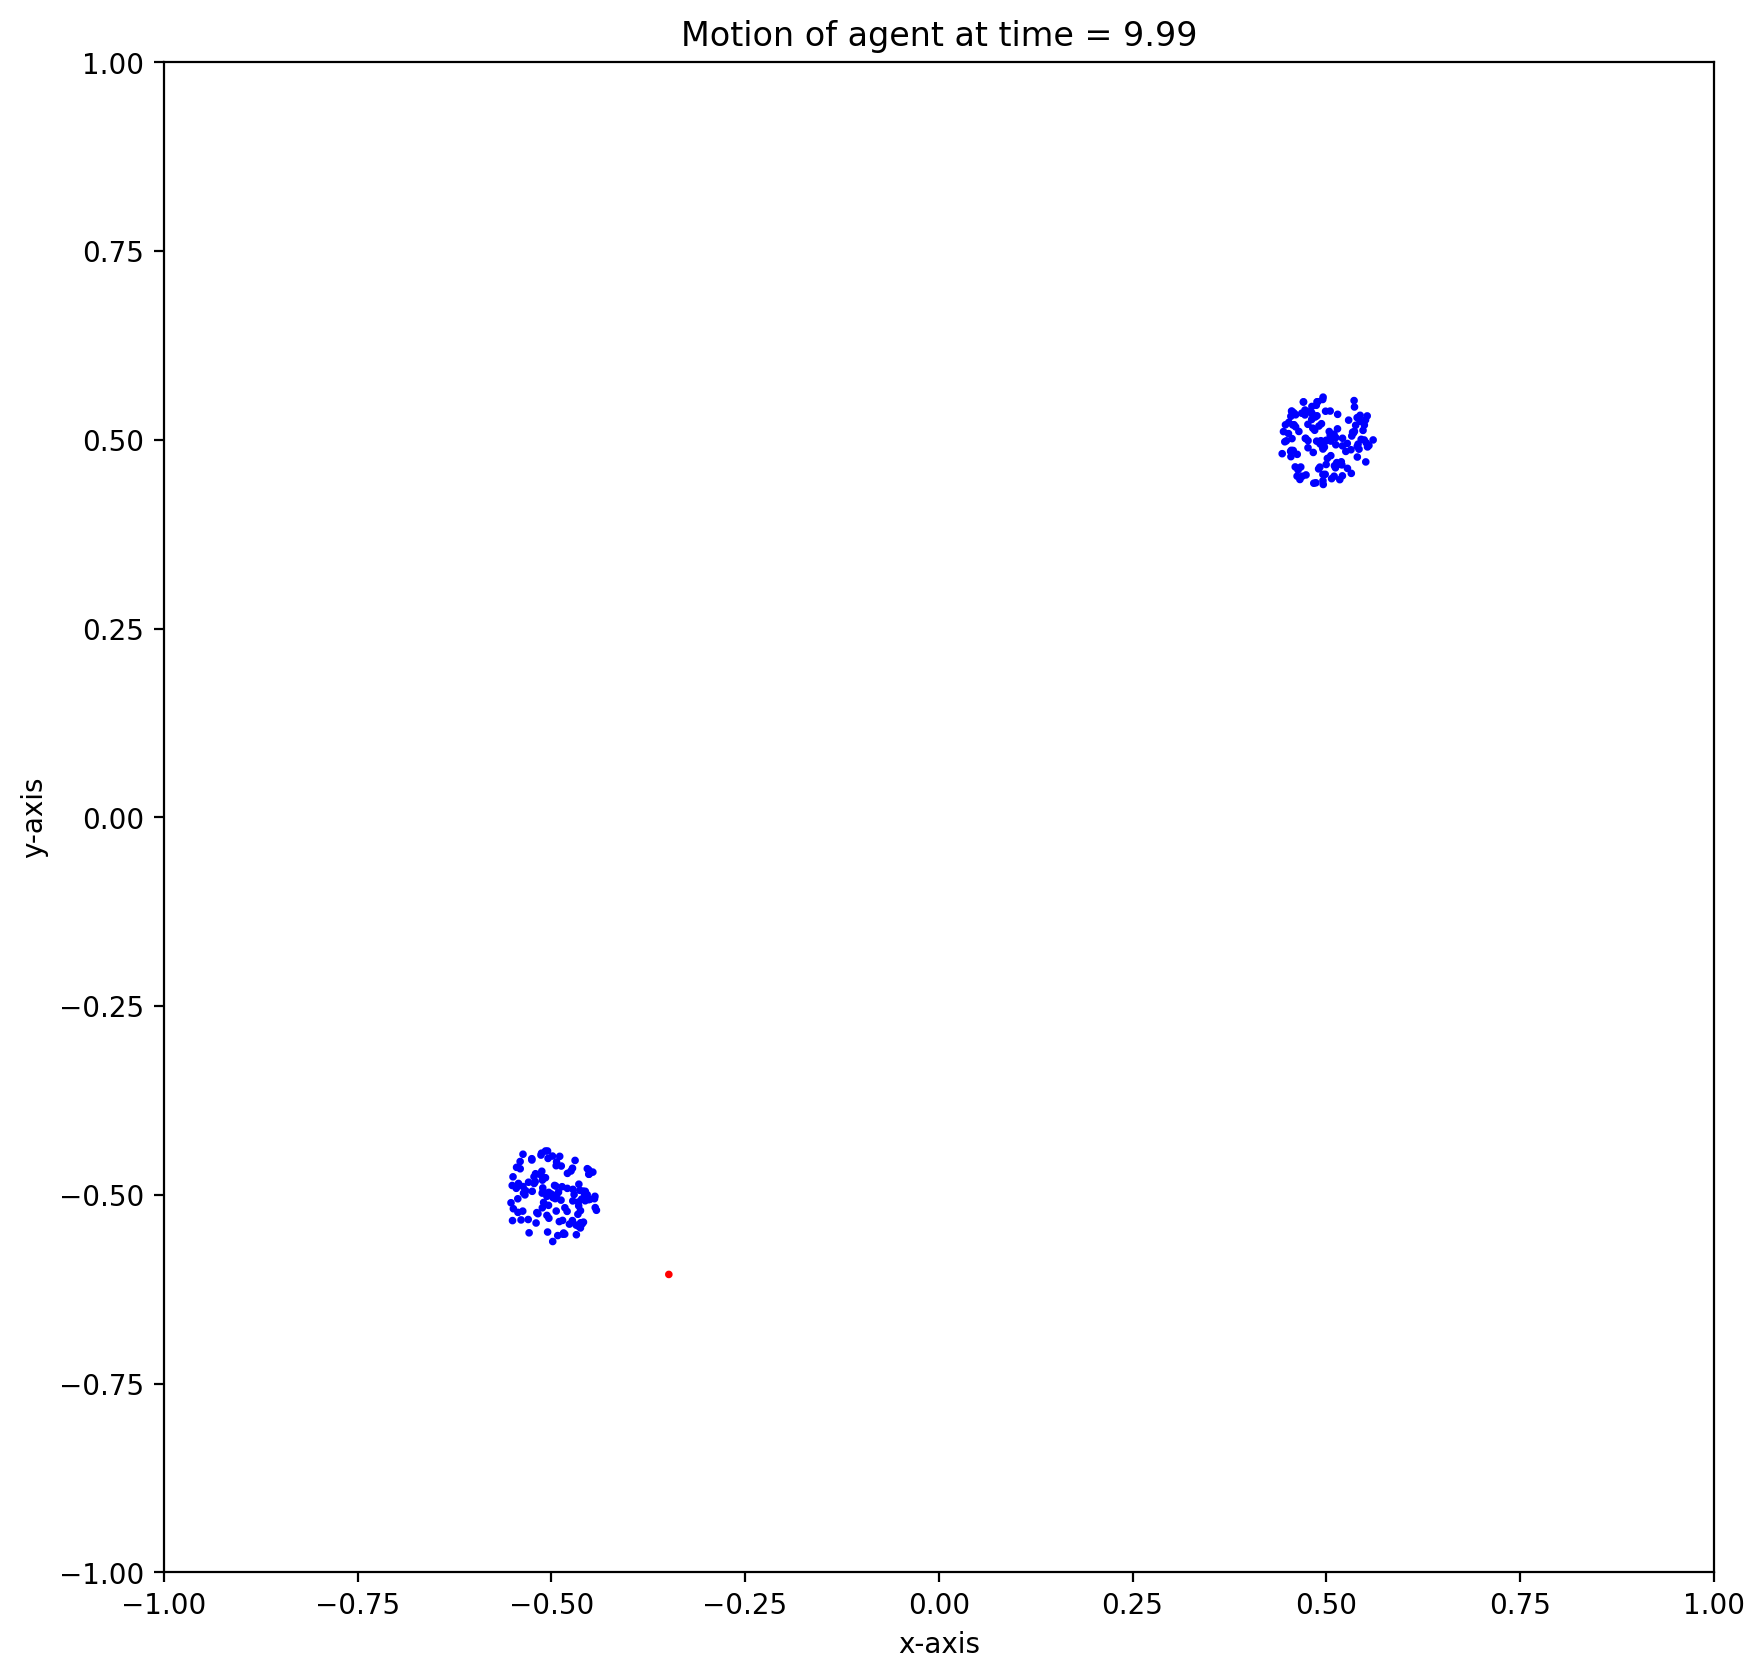

In [23]:
# We can create a quick animation just to make sure

# Agent motion properties
N_agents                = 250
acc_magnitude           = 2
desired_speed           = 0.5
randomness              = 4e-4
dt                      = 0.01
max_time                = 10
gradient_strength       = 10000
grad_radius             = 1e-4
grad_samples            = 50
bounds                  = np.array([[-1,1],[-1,1]])
steps                   = [50,50]
pheromone_level         = 1
pheromone_time_constant = 1
s                       = 0.2
A                       = 5
pos                     = np.array([None,None]) # np.array([0.5,0.5])

def func(x): 
    if len(x.shape) == 1:
        p1 = np.array([0.5,0.5])
        p2 = np.array([-0.5,-0.5])
        return -A*np.exp(-np.dot(x-p1,x-p1)/s**2) -A*np.exp(-np.dot(x-p2,x-p2)/s**2)
    else:
        return np.array([func(xi) for xi in x])
def F (x,y):
    p1 = np.array([0.5,0.5])
    p2 = np.array([-0.5,-0.5])
    return -np.exp(-((x-p1[0])**2 + (y-p1[1])**2)/s**2) -np.exp(-((x-p2[0])**2 + (y-p2[1])**2)/s**2)


# Now plot the position array
field = Field(bounds=bounds,steps=steps,function=func)

time = np.arange(0,max_time,dt)
A = [run_one_agent(field,dt,max_time,acc_magnitude,desired_speed,randomness,gradient_strength,grad_radius,grad_samples,pos,pheromone_level,pheromone_time_constant) for i in tqdm(range(N_agents))]
posA = [a[0] for a in A]
color = np.array([a[1] for a in A]).T

pos = []
for j in range(len(posA[0])):
    pos.append([])
    for i in range(len(posA)):
        pos[-1].append(posA[i][j])

pos = np.array(pos)

# Now we will define a figure
# Create the figure and setup athe axis
fig = plt.figure(figsize=(10,10),dpi=200)
ax  = fig.add_subplot(111)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('Motion of agent at time = %.2f'%time[0])
ax.set_xlim(*field.bounds[0])
ax.set_ylim(*field.bounds[1])

# Plot the mesh
x = np.linspace(*bounds[0],100)
y = np.linspace(*bounds[1],100)
X,Y = np.meshgrid(x,y)
Z = F(X,Y)
# ax.pcolormesh(X,Y,Z,cmap='terrain', shading='gouraud')

# Now the plot element
dot = plt.scatter(pos[0].T[0],pos[0].T[1],c=color[0],marker='o',s=3)

# Define our update function
def update(i):
    # Get some variables from the global scope
    global ax,dot,pos,time

    # Set our new data
    dot.set_offsets(pos[i])
    dot.set_color(color[i])
    ax.set_title('Motion of agent at time = %.2f'%time[i])

    return dot,

# Animate!
anim = animation.FuncAnimation(fig,update,frames=len(time),blit=True)
writer = animation.writers['ffmpeg'](fps=60)
anim.save('Animations/4_Particle_Test-%d.mp4'%anim_cnt,writer=writer,dpi=200)
anim_cnt+=1

## Adding a sense of direction

Now that we have implemented a way for the ants to move randomply around a terrain we should add a sense of directionality to them. How do we do this? We will utilize pheromone trails that different nodes will follow.

To do this effectively, we will have two basic states an agent can be in. One is a scout, the other is a worker.

1. The scouts wander around following the curvature of the original function - pheromones.
2. The scout becomes a worker if they can "fill in" the curvature with their pheromone. Then they stay there.


100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


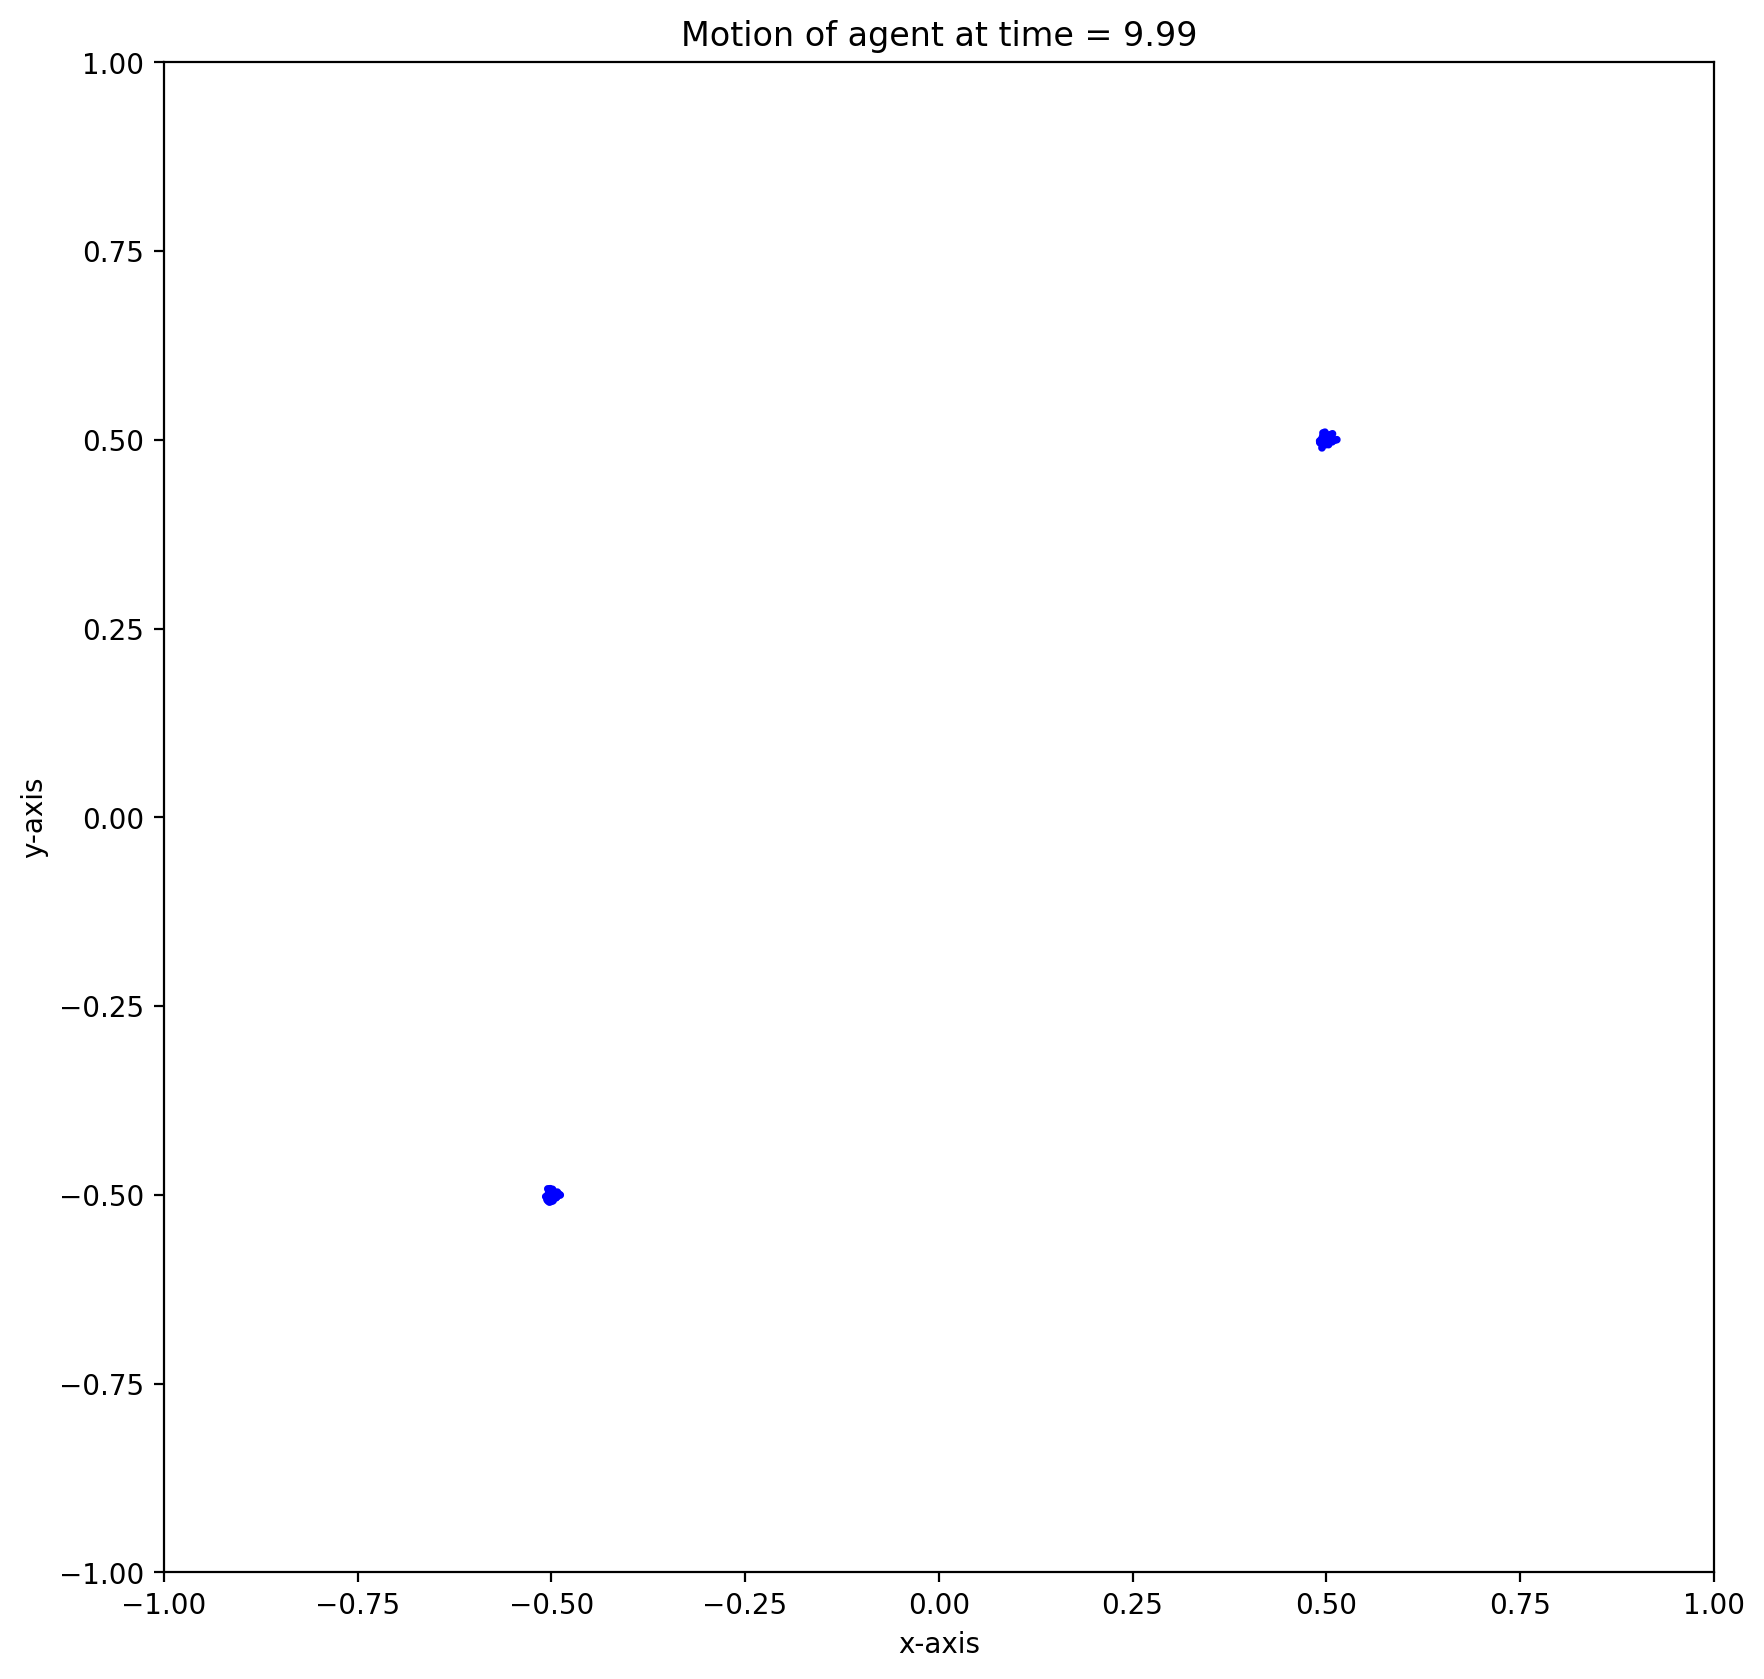

In [14]:
# We can create a second animation to with all the nodes run in parallel

# Agent motion properties
N_agents                = 100
acc_magnitude           = 2
desired_speed           = 0.5
randomness              = 4e-4
dt                      = 0.01
max_time                = 10
gradient_strength       = 10000
grad_radius             = 1e-4
grad_samples            = 10
bounds                  = np.array([[-1,1],[-1,1]])
steps                   = [50,50]
pheromone_level         = 1e+0
pheromone_time_constant = 1e+0
pheromone_strength      = 1e+4
pos                     = np.array([None,None]) # np.array([0.5,0.5])
field                   = Field(bounds=bounds,steps=steps,function=func)
s                       = 0.2
A                       = 20
def func(x): 
    if len(x.shape) == 1:
        p1 = np.array([0.5,0.5])
        p2 = np.array([-0.5,-0.5])
        return -A*np.exp(-np.dot(x-p1,x-p1)/s**2) -A*np.exp(-np.dot(x-p2,x-p2)/s**2)
    else:
        return np.array([func(xi) for xi in x])
def F (x,y):
    p1 = np.array([0.5,0.5])
    p2 = np.array([-0.5,-0.5])
    return -np.exp(-((x-p1[0])**2 + (y-p1[1])**2)/s**2) -np.exp(-((x-p2[0])**2 + (y-p2[1])**2)/s**2)

# Function to step the agnts
def run_n_agents(N_agents:int=N_agents,field:Field=field,dt=dt,max_time=max_time,acc_magnitude=acc_magnitude,desired_speed=desired_speed,randomness=randomness,gradient_strength=gradient_strength,grad_radius=grad_radius,grad_samples=grad_samples,pos=pos,pheromone_level = pheromone_level, pheromone_time_constant = pheromone_time_constant,pheromone_strength=pheromone_strength):
    # Create N agent
    agents = [Agent(pos=pos,field=field,pheromone_level=pheromone_level,pheromone_time_constant=pheromone_time_constant) for i in range(N_agents)]      # pos=np.array([0.5,0.5]),

    # Simulate the agent's motion for some arbitrary time
    time = np.arange(0,max_time,dt)
    
    # An array to solve the position
    pos = [[agent.pos for agent in agents]]
    color = [[COLORS[agent.state] for agent in agents]]

    # Simulate for the designated time
    for t in tqdm(time):
        for agent in agents:
            agent.update_velocity(dt,acc_magnitude,desired_speed,randomness,gradient_strength,grad_radius,grad_samples,pheromone_strength,t)
            agent.move(dt)
            agent.update_state(t)

        pos.append([agent.pos for agent in agents])
        color.append([COLORS[agent.state] for agent in agents])

    pos = np.array(pos)
    color = np.array(color)

    return pos,color


# Now plot the position array
time = np.arange(0,max_time,dt)
pos,color = run_n_agents()

# Now we will define a figure
# Create the figure and setup athe axis
fig = plt.figure(figsize=(10,10),dpi=200)
ax  = fig.add_subplot(111)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('Motion of agent at time = %.2f'%time[0])
ax.set_xlim(*field.bounds[0])
ax.set_ylim(*field.bounds[1])

# Plot the mesh
x = np.linspace(*bounds[0],100)
y = np.linspace(*bounds[1],100)
X,Y = np.meshgrid(x,y)
Z = F(X,Y)
# ax.pcolormesh(X,Y,Z,cmap='terrain', shading='gouraud')

# Now the plot element
dot = plt.scatter(pos[0].T[0],pos[0].T[1],c=color[0],marker='o',s=3)

# Define our update function
def update(i):
    # Get some variables from the global scope
    global ax,dot,pos,time

    # Set our new data
    dot.set_offsets(pos[i])
    dot.set_color(color[i])
    ax.set_title('Motion of agent at time = %.2f'%time[i])

    return dot,

# Animate!
anim = animation.FuncAnimation(fig,update,frames=len(time),blit=True)
writer = animation.writers['ffmpeg'](fps=60)
anim.save('Animations/6_Particle_Test-1.mp4',writer=writer,dpi=200)

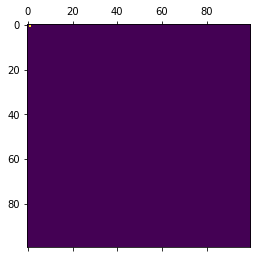

In [76]:
A = field.get_pheromones(max_time,1)
np.where(A!=0)
plt.matshow(A)

In [30]:
x = np.array([-2,1])
bounds = np.array([[-1,1],[0,0.1]])
[np.sign(bi.mean() - xi) if (xi-bi[0])*(xi-bi[1]) >0 else 0 for xi,bi in zip(x,bounds)]

[1.0, -1.0]